<a href="https://colab.research.google.com/github/bhavyasingh75/covid-detection/blob/main/attempt101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5f2c27d1-558c-4907-4088-5b103e01be61)


In [1]:
import tensorflow as tf

In [2]:
# List all physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid TensorFlow from consuming all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Optionally, limit TensorFlow to use a fraction of GPU memory
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    except RuntimeError as e:
        print(e)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile #ONLY ONCE

zip_file_path = '/content/drive/MyDrive/project-dataset/chest-xray-2.zip'  # Replace with actual path
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/drive/MyDrive/project-dataset/trial')
    print("Dataset unzipped successfully!")
except Exception as e:
    print(f"Error unzipping dataset: {e}") # Replace '/content/data' with desired extraction directory

Dataset unzipped successfully!


# Step 1: Importing Required Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
import random, cv2
import os
from glob import glob
from keras.preprocessing.image import load_img

import tensorflow_hub as hub

from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay



import warnings
warnings.simplefilter('ignore')

In [ ]:
#Context-Free Grammar (CFG):
class CFG:
    EPOCHS= 50
    BATCH_SIZE= 64
    SEED= 42
    TF_SEED= 768
    HEIGHT= 224
    WIDTH= 224
    CHANNELS= 3
    IMAGE_SIZE=(224,224,1)

# Step-2: Define dataset paths and load images

In [6]:
data_dir = '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset'

In [7]:
#summary of dataset:
for dirpath,dirnames,filenames in os.walk("/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 4 directories and 5 images in '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset'.
there are 2 directories and 0 images in '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset/COVID'.
there are 0 directories and 3616 images in '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset/COVID/images'.
there are 0 directories and 3616 images in '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset/COVID/masks'.
there are 2 directories and 0 images in '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset/Lung_Opacity'.
there are 0 directories and 6012 images in '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset/Lung_Opacity/images'.
there are 0 directories and 6012 images in '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset/Lung_Opacity/masks'.
there are 2 directories and 0 images in '/content/drive/MyDrive/project-dataset/trial/

In [10]:
# dictionary to map the different classes in the dataset
data_class_dict = {
    'COVID' : 'Covid-19',
    'Lung_Opacity' : 'Lung Opacity',
    'Normal' : 'Healthy',
    'Viral Pneumonia' : 'Viral Pneumonia'
}

# dictionary to map the different classes in the dataset in numerical form
data_code_dict = {
    'COVID' : 0,
    'Lung_Opacity' : 1,
    'Normal' : 2,
    'Viral Pneumonia' : 3
}

In [11]:
data_dir = '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset'

# Assuming your classes are named "Class1", "Class2", "Class3", and "Class4"
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# This dictionary will store the paths to image folders for each class
image_folder_paths = {cls: os.path.join(data_dir, cls, 'images') for cls in classes}

# This list will store the paths to all image files
image_paths = []

# Iterate through each class folder and collect image paths
for cls, folder_path in image_folder_paths.items():
  image_paths.extend(glob(os.path.join(folder_path, '*.png'), recursive=False))  # Adjust extension if needed

# Create the image_id_path_dict using the collected image paths
image_id_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}

In [12]:
# print(list(image_id_path_dict.items())[0])
# print(list(image_id_path_dict.items())[-5])
print(list(image_id_path_dict.items())[2000])
print(list(image_id_path_dict.items())[15000])

('COVID-1553', '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset/COVID/images/COVID-1553.png')
('Normal-4933', '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset/Normal/images/Normal-4933.png')


In [13]:
# creating a dataframe using the dictionary created
# with the image_id and its respective path as columns

covid_df = pd.DataFrame.from_dict(image_id_path_dict, orient = 'index').reset_index()
covid_df.columns = ['Image_id', 'Path']

# creating a new column class using the image_id
covid_df['class'] = covid_df['Image_id'].apply(lambda x:x.split('-')[0]) # getting the first element after splitting
covid_df.head()

,Image_id,Path,class
0,COVID-3353,/content/drive/MyDrive/project-dataset/trial/C...,COVID
1,COVID-3354,/content/drive/MyDrive/project-dataset/trial/C...,COVID
2,COVID-3355,/content/drive/MyDrive/project-dataset/trial/C...,COVID
3,COVID-3356,/content/drive/MyDrive/project-dataset/trial/C...,COVID
4,COVID-3357,/content/drive/MyDrive/project-dataset/trial/C...,COVID


In [14]:
# mapping the values to the class column
# to the dictionary data_class_dict using map()

covid_df['Class'] = covid_df['class'].map(data_class_dict.get)
covid_df['Class'].value_counts()

Class
Healthy            10192
Lung Opacity        6012
Covid-19            3616
Viral Pneumonia     1345
Name: count, dtype: int64

In [ ]:
# mapping numerical values to the class column
# to the dictionary data_code_dict using map()

covid_df['Target'] = covid_df['class'].map(data_code_dict.get)
covid_df['Target'].value_counts()

Target
2    10192
1     6012
0     3616
3     1345
Name: count, dtype: int64

In [15]:
# # resizing the shape of the images
# # and adding it to the dataframe

covid_df['Image'] = covid_df['Path'].apply(lambda x:np.asarray(Image.open(x).resize((124, 124))))

KeyboardInterrupt: 

# Step 4: View multiple and single randomly selected image

In [ ]:
# function to display random images with respect to class

def display_image(class_type):
    plt.figure(figsize = (12, 8)) # setting the figure size

    temp = covid_df[covid_df['Class'] == class_type]['Path'] # getting the image path of the class
    start = random.randint(0, len(temp)) # selecting a random starting index
    files = temp[start:start+3] # getting the next 2 image paths

    for index, file in enumerate(files):
        plt.subplot(1, 3, index+1)
        img = load_img(file) # loading the image
        img = np.array(img) # converting the image to an array
        plt.imshow(img) # displaying the image
        plt.title(class_type) # title for the image
        plt.axis('off') # disabling the axis

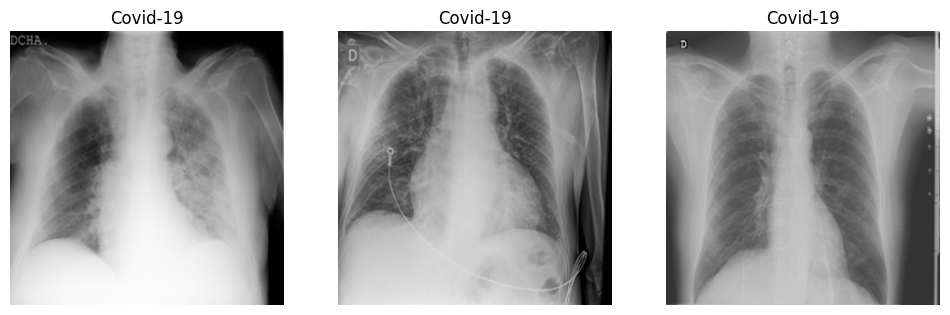

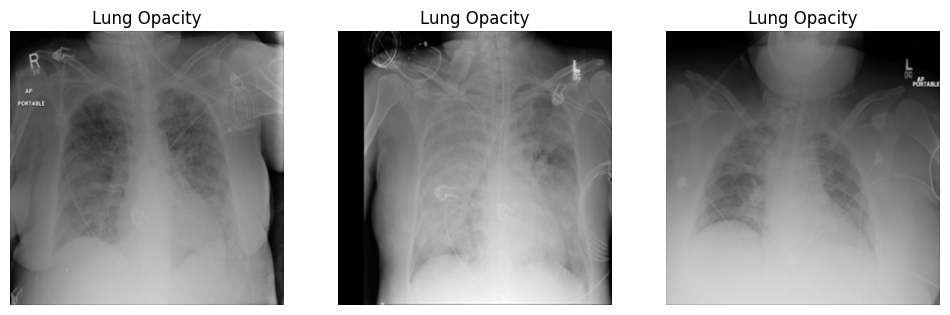

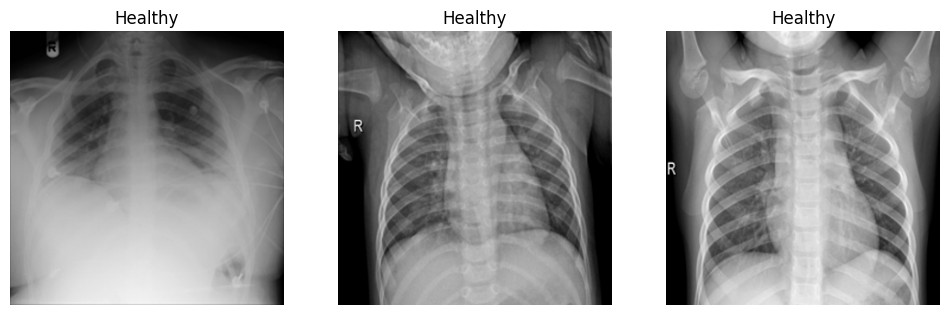

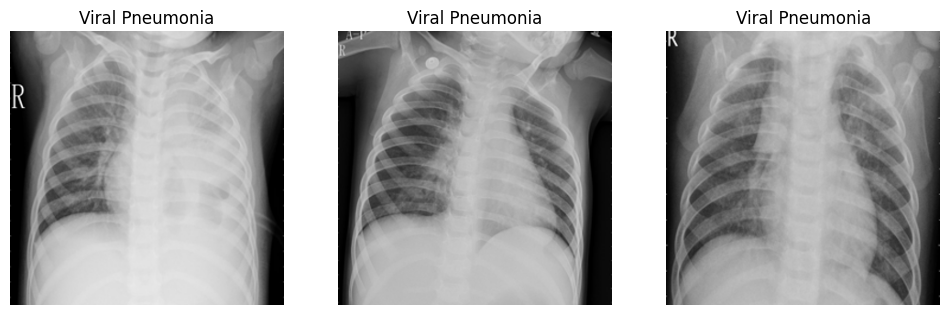

In [ ]:
# 3 random images for each class

for cls in covid_df['Class'].unique():
    display_image(cls)

# Step 5: Creating train/val split with training + Building augmentation layer


In [16]:
base_dir = '/content/drive/MyDrive/project-dataset/trial/COVID-19_Radiography_Dataset' # base directory of the image

classes = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"] # all the classes
num_classes = len(classes)

epochs = 50
batch_size = 64

# parameters to create the training and validation set images
# and data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale = 1./255, # normalizing the pixel value of images
    horizontal_flip = True, # used for randomly flipping the  inputs horizontally.
    width_shift_range = 0.2, # specifying the range to be shifted on the left and right sides
    height_shift_range = 0.2, # specifying the range to be shifted on the top and bottom sides
    zoom_range = 0.2,
    rotation_range = 20, # specifying the rotation angle
    # shear_range=0.2,  # Adding shear transformation
    fill_mode='nearest',  # Filling in missing pixels after transformations
    validation_split = 0.2
)

# No data augmentation is performed on test data images
test_datagen = ImageDataGenerator(
    rescale = 1./255, # normalizing the pixel value of images
    validation_split = 0.2 # percentage of validation data
)

In [17]:
# loading the images for training
train_gen = train_datagen.flow_from_directory(
    directory = base_dir, # directory of the image
    target_size = (124, 124), # size of the image
    class_mode = 'categorical', # type of classification
    shuffle = True, # enabling shuffling within the images
    subset = 'training',
    classes = classes, # passing the list of classes
    batch_size = batch_size, # setting the batch size
    color_mode = 'grayscale' # setting the color mode
)

# loading the images for testing
test_gen = test_datagen.flow_from_directory(
    directory = base_dir, # directory of the images
    target_size=(124, 124),
    class_mode = 'categorical', # type of classification
    subset = 'validation',
    shuffle = False, # disabling shuffling within the images
    batch_size = batch_size, # setting the batch size
    color_mode = 'grayscale' # setting the color mode
)

Found 33866 images belonging to 4 classes.
Found 8464 images belonging to 4 classes.


In [18]:
train_labels = train_gen.classes

In [19]:
test_labels = test_gen.classes

In [ ]:
print(f"Train Labels Shape: {test_labels.shape}")
print(f"Test Predictions Shape: {test_pred.shape}")


# Step-6: CNN Model Building

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [ ]:
# setting up the cnn model

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3),activation='relu',padding = 'Same', input_shape=(124, 124, 1))) # convolutional layer
model.add(MaxPooling2D(pool_size = (2, 2))) # layer for max pooling

model.add(Conv2D(16, kernel_size = (3, 3),activation='relu',padding = 'Same')) # convolutional layer
model.add(MaxPooling2D(pool_size = (2, 2))) # layer for max pooling

model.add(Conv2D(8, kernel_size = (3, 3),activation='relu',padding = 'Same')) # convolutional layer
model.add(MaxPooling2D(pool_size = (2, 2))) # layer for max pooling

model.add(Flatten()) # flattening the image array
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax')) # Dense layer

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 8)         0

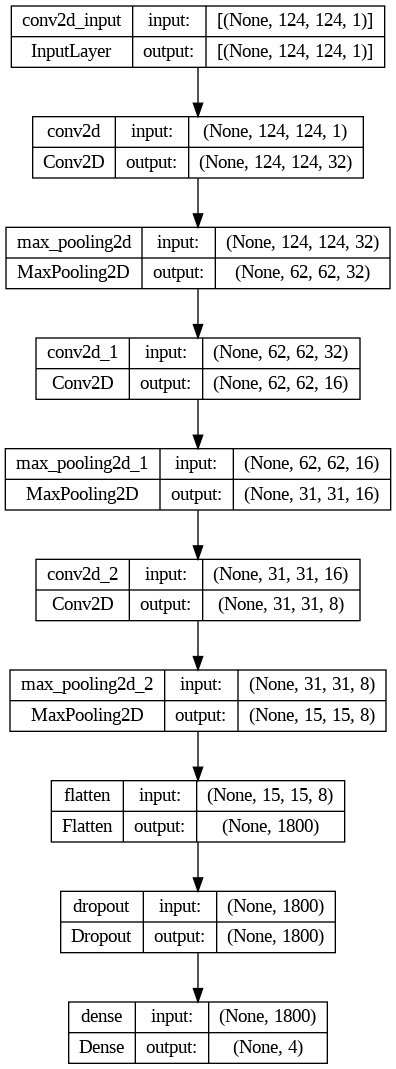

In [ ]:
#plot model layer
from tensorflow import keras
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
# def cnn_model():
#     initializer= tf.keras.initializers.GlorotNormal()
#     cnn_sequential = Sequential([
#         layers.Input(shape=CFG.IMAGE_SIZE,dtype=tf.float32, name='input_image'),
#         layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
#         layers.Conv2D(16,kernel_size=3, activation='relu', kernel_initializer=initializer),
#         layers.MaxPool2D(pool_size=2,padding='valid'),


#         layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
#         layers.Conv2D(8,kernel_size=3, activation='relu', kernel_initializer=initializer),
#         layers.MaxPool2D(pool_size=2),


#         layers.Flatten(),
#         layers.Dropout(0.5),
#         layers.Dense(128, activation='relu', kernel_initializer=initializer),
#         layers.Dropout(0.5),
#         layers.Dense(3, activation='softmax', kernel_initializer=initializer),
#     ], name='cnn_sequential_model')
#     return cnn_sequential

In [ ]:
# model_cnn = cnn_model()
# model_cnn.summary()

# Step 7: Training and Validating Custom CNN Model

In [27]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint

# early stopping parameter with patience of 20 epochs
early_stopping = EarlyStopping(patience = 3, mode = 'min', verbose = 1)

checkpoint_path = "/content/drive/MyDrive/project-dataset/model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, save_weights_only=True) # only save model weights (not whole model)

# learning rate reduction when the validation accuracy does not improve
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 1,
                                            factor = 0.2, min_lr = 1e-7)

callbacks = [early_stopping,model_checkpoint,learning_rate_reduction]

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Model training with GPU
with tf.device('/GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=test_gen,
        steps_per_epoch=train_gen.samples // batch_size,
        validation_steps=test_gen.samples // batch_size,
        epochs=epochs,
        callbacks=callbacks
    )

Epoch 1/50
529/529 [==============================] - 251s 463ms/step - loss: 1.1686 - accuracy: 0.4845 - val_loss: 1.1079 - val_accuracy: 0.5154 - lr: 0.0010
Epoch 2/50
529/529 [==============================] - 236s 446ms/step - loss: 1.0899 - accuracy: 0.5243 - val_loss: 0.8828 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 3/50
529/529 [==============================] - 235s 445ms/step - loss: 1.0255 - accuracy: 0.5526 - val_loss: 0.8700 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 4/50
529/529 [==============================] - 236s 447ms/step - loss: 0.9919 - accuracy: 0.5747 - val_loss: 0.8036 - val_accuracy: 0.6541 - lr: 0.0010
Epoch 5/50
529/529 [==============================] - 236s 446ms/step - loss: 0.9720 - accuracy: 0.5847 - val_loss: 0.7750 - val_accuracy: 0.6707 - lr: 0.0010
Epoch 6/50
529/529 [==============================] - 235s 445ms/step - loss: 0.9528 - accuracy: 0.5974 - val_loss: 0.7777 - val_accuracy: 0.6714 - lr: 0.0010
Epoch 7/50
529/529 [==========================

In [ ]:
test_pred = model.predict(test_gen)
test_pred

133/133 [==============================] - 38s 286ms/step


array([[1.4458099e-01, 6.5741473e-01, 1.9759315e-01, 4.1116209e-04],
       [3.0937690e-01, 5.8349597e-01, 9.8313995e-02, 8.8131484e-03],
       [1.2735975e-01, 4.7973655e-02, 8.2464993e-01, 1.6640195e-05],
       ...,
       [8.7183788e-02, 8.7843619e-02, 1.4854841e-01, 6.7642415e-01],
       [3.3701722e-02, 4.8673511e-02, 1.6583921e-01, 7.5178552e-01],
       [5.8769610e-02, 5.0830953e-02, 2.1621856e-01, 6.7418087e-01]],
      dtype=float32)

In [ ]:
# evaluating the model on the test data

model.evaluate_generator(test_gen)

[0.7376961708068848, 0.6882088780403137]

In [ ]:
model.save("/content/drive/MyDrive/project-dataset/trained-model/best-model.h5")

In [ ]:
#model-loading
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/project-dataset/trained-model/best-model.h5")

# Step 8: Plot the Training Loss, Validation Loss, Training Accuracy, Validation Accuracy

In [ ]:
acc = history.history['accuracy'] # training accuracy
val_acc = history.history['val_accuracy'] # validation accuracy
epochs = range(len(acc)) # number of epochs

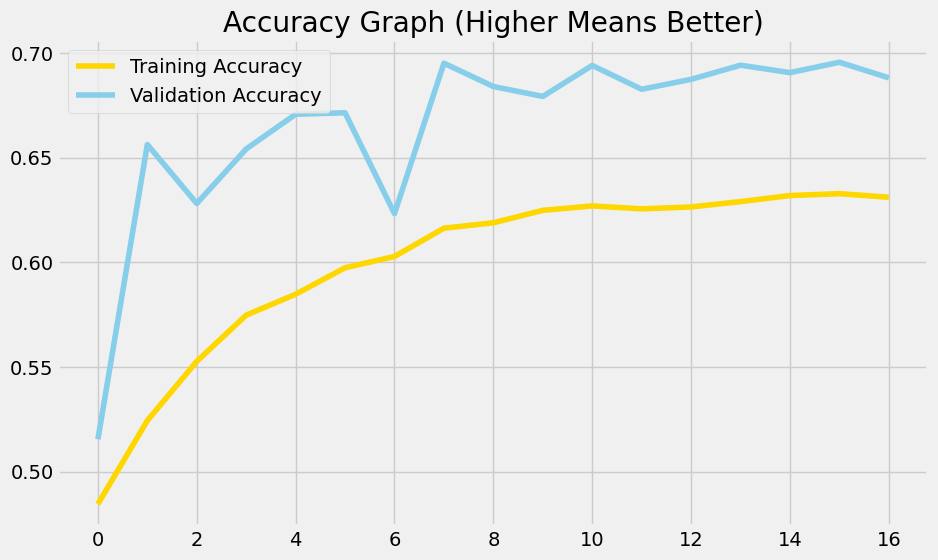

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (10, 6))
plt.plot(epochs, acc, 'gold', label='Training Accuracy') # line plot for training accuracy
plt.plot(epochs, val_acc, 'skyblue', label='Validation Accuracy') # line plot for validation accuracy
plt.title('Accuracy Graph (Higher Means Better)') # title of the plot
plt.legend() # setting legend for the plot
plt.show()

In [ ]:
loss = history.history['loss'] # training loss
val_loss = history.history['val_loss'] # validation loss

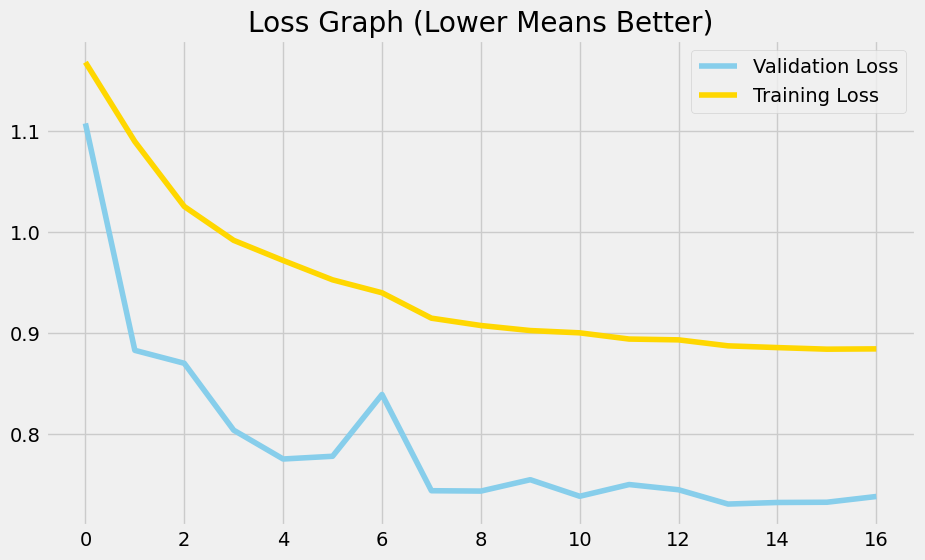

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (10, 6))

plt.plot(epochs, val_loss, 'skyblue', label='Validation Loss') # line plot of validation loss
plt.plot(epochs, loss, 'gold', label='Training Loss') # line plot of training loss
plt.title('Loss Graph (Lower Means Better)') # title of the plot
plt.legend() # setting legend for the plot
plt.show()

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(test_labels, test_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      train_labels: true labels in the form of a 1D array
      test_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(test_labels, test_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(test_labels, test_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results


In [ ]:
# Assuming test_pred contains probabilities
predicted_labels = np.argmax(test_pred, axis=1)  # Extract predicted class labels

# Call the calculate_results function
evaluation_results = calculate_results(test_labels, predicted_labels)

# Print the results in a user-friendly format
print("Evaluation Results:")
print(f"Accuracy: {evaluation_results['accuracy']:.2f}%")
print(f"Precision: {evaluation_results['precision']:.4f}")
print(f"Recall: {evaluation_results['recall']:.4f}")
print(f"F1-Score: {evaluation_results['f1']:.4f}")

Evaluation Results:
Accuracy: 68.82%
Precision: 0.7096
Recall: 0.6882
F1-Score: 0.6443


# Step 9: Fine-Tuning Deep Learning Models for Multimodal Chest X-Rays

1. EfficientNetB0
2. ResNet50V2
3. InceptionV3
4. DenseNet121
